In [1]:
import os
import sys
import random
from glob import glob
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

# enable use of local modules
repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.instruments.hwo import HWO
from mejiro.synthetic_image import SyntheticImage
from mejiro.galaxy_galaxy import GalaxyGalaxy, SampleGG, SampleBELLS, SampleSL2S
from mejiro.exposure import Exposure
from mejiro.utils import util

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# set HWO directory
hwo_dir = os.path.join(repo_dir, 'hwo')

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
synthetic_image = SyntheticImage(strong_lens=SampleGG(),
                                instrument=HWO(),
                                band='J',
                                fov_arcsec=5,
                                pieces=True,
                                verbose=True)

engine_params = {
    'sky_background': True,
    'detector_effects': True,
}

exposure = Exposure(synthetic_image,
                    exposure_time=1e1,
                    engine_params=engine_params,
                    verbose=True)

Exposure calculation time with galsim engine: 0:00:00


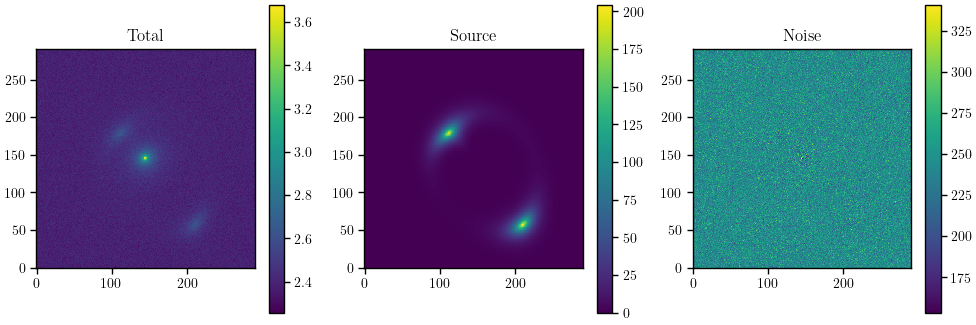

In [3]:
_, ax = plt.subplots(1, 3, figsize=(12, 4))

vmin = np.min([exposure.exposure, exposure.noise])
vmax = np.max([exposure.exposure, exposure.noise])

plot_kwargs = {
    'cmap': 'viridis', 
    'vmin': vmin, 
    'vmax': vmax
}

im0 = ax[0].imshow(np.log10(exposure.exposure))
im1 = ax[1].imshow(exposure.source_exposure)
im2 = ax[2].imshow(exposure.noise)

plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Source')
ax[2].set_title('Noise')

plt.show()

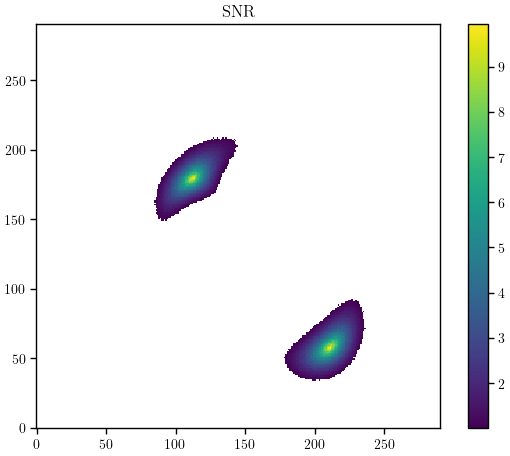

In [39]:
snr_per_pixel_threshold = 1

snr_array = exposure.source_exposure / np.sqrt(exposure.exposure)
masked_snr_array = np.ma.masked_where(snr_array <= snr_per_pixel_threshold, snr_array)

plt.imshow(masked_snr_array)
plt.colorbar()
plt.title('SNR')
plt.show()

Number of features: 2


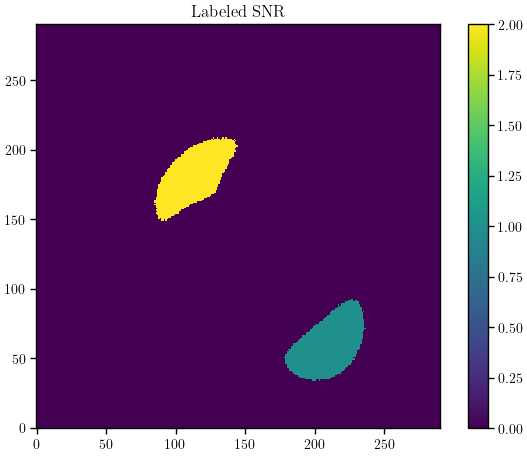

In [40]:
from scipy import ndimage

structure = np.array([[1, 1, 1],
                     [1, 1, 1],
                     [1, 1, 1]])
labeled_array, num_features = ndimage.label(masked_snr_array.filled(0), structure=structure)
print(f'Number of features: {num_features}')

plt.imshow(labeled_array)
plt.colorbar()
plt.title('Labeled SNR')
plt.show()

In [41]:
snrs = []
for i in range(1, num_features + 1):
    source_counts = np.sum(exposure.source_exposure[labeled_array == i])
    total_counts = np.sum(exposure.exposure[labeled_array == i])
    snr = source_counts / np.sqrt(total_counts)
    snrs.append(snr)
    print(f'Feature {i}: SNR = {snr:.2f}')

Feature 1: SNR = 123.37
Feature 2: SNR = 115.88


Compare with old SNR method

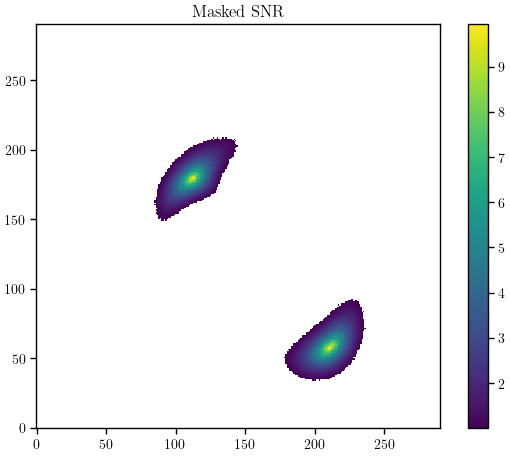

Number of regions: 7
SNR list: [123.3736668390771, 1.0069010893441837, 1.0156125119150057, 115.88530380008947, 1.0100875727491168, 1.0390283720876134, 1.0106428389424826]
SNR: 123.37


In [10]:
from mejiro.analysis import regions

# calculate SNR in each pixel
snr_array = np.nan_to_num(exposure.source_exposure / np.sqrt(exposure.exposure))
masked_snr_array = np.ma.masked_where(snr_array <= 1, snr_array)

# speed up region-identifying code by removing single pixel regions
masked_snr_array = regions.remove_single_pixels(masked_snr_array)

plt.imshow(masked_snr_array)
plt.colorbar()
plt.title('Masked SNR')
plt.show()

# calculate regions of connected pixels given the snr mask
indices_list = regions.get_regions(masked_snr_array, debug_dir=None)

snr_list = []
for region in indices_list:
    numerator, denominator = 0, 0
    for j, i in region:
        numerator += exposure.source_exposure[i, j]
        denominator += exposure.exposure[i, j]
    if denominator <= 0.:
        continue
    snr = numerator / np.sqrt(denominator)
    assert not np.isnan(snr), 'NaN in SNR list'
    assert not np.isinf(snr), 'Inf in SNR list'
    snr_list.append(snr)

print(f'Number of regions: {len(snr_list)}')
print(f'SNR list: {snr_list}')
print(f'SNR: {np.max(snr_list):.2f}')

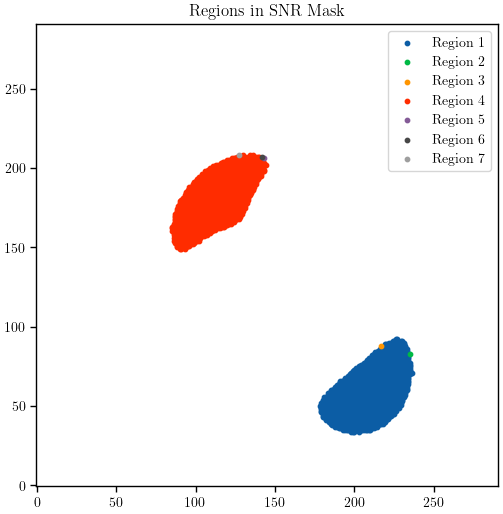

In [13]:
_, ax = plt.subplots(figsize=(6, 6))

# Plot the masked SNR array as the background
ax.imshow(masked_snr_array, cmap='viridis')

# Plot each region's coordinates
for region in indices_list:
    region_coords = np.array(region)
    ax.scatter(region_coords[:, 0], region_coords[:, 1], s=10, label=f'Region {indices_list.index(region) + 1}')

ax.set_title('Regions in SNR Mask')
ax.legend()
plt.show()

Compare speed with new SNR method